# ライブラリのインポート

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb
import shap
from sklearn.metrics import log_loss


# 特徴量エンジニアリング
1. 使わない特徴量を削除
2. カテゴリカルデータをラベルエンコーディング 
3. 欠損値を埋める。(LightGBM)
4. データの特性から特徴量を追加

In [21]:
df = pd.read_csv("train.csv")

In [22]:
cabin_split = df['Cabin'].str.split('/', expand=True)
# Deck 列を作成
df['Deck'] = cabin_split[0]    
# Side 列を作成し、条件に基づいて数値を割り当て
df['Side'] = cabin_split[2].map({'P': True, 'S': False})
df['Side'] = df['Side'].astype(bool)

# PassengerId から GroupID と Person Number を抽出
df['GroupID'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
# Group Size を計算
group_sizes = df.groupby('GroupID').size()
df['GroupSize'] = df['GroupID'].apply(lambda x: group_sizes[x])
# Is Alone 特徴量を追加
df['IsAlone'] = (df['GroupSize'] == 1).astype(int)

In [23]:
drop_cols = ['PassengerId', 'Cabin', 'Name','GroupID']
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination','VIP','Deck','Side', 'IsAlone' ,'GroupSize']

In [24]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # カラム数に基づいて行と列の数を設定

# cols = 3  # 3列で表示
# rows = (len(cat_cols) + cols - 1) // cols  # 必要な行数を計算

# # サブプロットの設定
# fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))  # 各サブプロットのサイズを調整
# axes = axes.flatten()  # 1Dに変換してインデックスでアクセスしやすくする

# # 各カラムについてプロット
# for i, name in enumerate(cat_cols):
#     sns.countplot(x=name, hue='Transported', data=df, ax=axes[i])
#     axes[i].set_title(f'{name} vs. Transported')
#     axes[i].tick_params(axis='x', rotation=45)  # x軸のラベルを回転して表示

# # 余分なサブプロットを非表示
# for j in range(i + 1, len(axes)):
#     axes[j].axis('off')

# plt.tight_layout()
# plt.show()


In [25]:
df_drop = df.drop(drop_cols, axis=1)

In [26]:
# RoomService の欠損値を条件に基づいて埋める
df_drop['RoomService'] = df_drop.apply(
    lambda row: 0 if pd.isna(row['RoomService']) and row['CryoSleep'] else row['RoomService'],
    axis=1
)


In [27]:
for c in cat_cols:
    le = LabelEncoder()
    le.fit(df_drop[c])
    df_drop[c] = le.transform(df_drop[c])

for c in cat_cols:
    df_drop[c] = df_drop[c].astype('category')

In [28]:
columns_with_nulls = [col for col in df_drop.columns if df_drop[col].isna().any()]
data = df_drop.drop(['Transported'], axis=1)
for c in columns_with_nulls:
    print('-'*100)
    print(c)

# 欠損値がある行とない行を分ける
    train_data = data[data[c].notna()]
    test_data = data[data[c].isna()]

# 訓練データと検証データ
    X_train, X_val, y_train, y_val = train_test_split(
        train_data.drop(c, axis=1), 
        train_data[c],
        test_size=0.2,
        random_state=42
    )
    objective = 'multiclass' if c in ['HomePlanet', 'CryoSleep', 'Destination','VIP','Deck','Side', 'IsAlone' ,'GroupSize'] else 'regression'

# LightGBMのパラメータ
    params = {
        'objective': objective,  # 目的変数が連続値の場合は'regression', カテゴリの場合は'multiclass'
        'learning_rate': 0.1,
        'lambda_l1' : 0.1,
        'num_leaves': 20,
        'random_state': 4
    }

# 訓練データセットを作成
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

# モデルの訓練
    model = lgb.train(params,
                      dtrain,
                      num_boost_round=10000,
                      valid_sets=[dtrain, dval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                      lgb.log_evaluation(500)])

# テストデータで欠損値を予測
    predicted_values = model.predict(test_data.drop(c, axis=1))

# 欠損値の予済結果を元のデータセットに埋める
    data.loc[data[c].isna(), c] = predicted_values

----------------------------------------------------------------------------------------------------
Age
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1317
[LightGBM] [Info] Number of data points in the train set: 6811, number of used features: 13
[LightGBM] [Info] Start training from score 28.770518
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	train's l2: 150.751	valid's l2: 166.763
----------------------------------------------------------------------------------------------------
RoomService
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGB

In [29]:
data['total_usage'] = data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa']].sum(axis=1)
data['is_youth'] = np.where(data['Age'] >= 40, 0, 1)


# 訓練データの分割

In [30]:

#X = df_drop.drop(['Transported'], axis=1)
X = data
y = df_drop['Transported']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0 )
"""
最初にデータを訓練データとテストデータに分割
次に訓練データをさらに訓練データと検証データに分割
X_train, y_train : 訓練データ
X_val, y_val : 検証データ
X_test, y_test : テストデータ
"""

'\n最初にデータを訓練データとテストデータに分割\n次に訓練データをさらに訓練データと検証データに分割\nX_train, y_train : 訓練データ\nX_val, y_val : 検証データ\nX_test, y_test : テストデータ\n'

# モデルの構築(クロスバリデーション)

In [32]:
params = {
    'objective': 'binary',
    'num_leaves': 10,
    'seed': 0,
    'verbose': -1,
}

In [33]:
from sklearn.metrics import log_loss
def crossVal(X_train, y_train, params):
    # 格納用データの作成
    valid_scores = []
    models = []
    oof = np.zeros(len(X_train))

    # KFoldを用いて学習データを5分割してモデルを作成
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
        X_tr = X_train.iloc[tr_idx]
        X_va = X_train.iloc[va_idx]
        y_tr = y_train.iloc[tr_idx]
        y_va = y_train.iloc[va_idx]
    
        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

        # 最適化ハイパーパラメータを読み込み
        model = lgb.train(params,
                      lgb_train,
                      num_boost_round=10000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                      lgb.log_evaluation(500)])

        y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
        score = log_loss(y_va, y_va_pred)  # loglossで評価
        print(f'fold {fold+1} logloss valid: {score:.5f}')  # 表示形式を調整

        # スコア、モデル、予測値の格納
        valid_scores.append(score)
        models.append(model)
        oof[va_idx] = y_va_pred
    return valid_scores, models,oof

# クロスバリデーションの平均スコア
valid_scores, models,oof = crossVal(X_train, y_train, params)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[343]	train's binary_logloss: 0.278369	valid's binary_logloss: 0.377027
fold 1 logloss valid: 0.37703
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	train's binary_logloss: 0.328394	valid's binary_logloss: 0.368127
fold 2 logloss valid: 0.36813
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[235]	train's binary_logloss: 0.30402	valid's binary_logloss: 0.412744
fold 3 logloss valid: 0.41274
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	train's binary_logloss: 0.351977	valid's binary_logloss: 0.415968
fold 4 logloss valid: 0.41597
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[175]	train's binary_logloss: 0.327097	valid's binary_logloss: 0.371737
fold 5 logloss valid: 0.37174
Traini

# テストデータで検証

In [34]:
def predict(submi_data,models):
    output = np.zeros_like(models[0].predict(submi_data))
    for i in range(len(models)):
        output += models[i].predict(submi_data)
       
        
    output = output / len(models)
    return np.round(output).astype(bool)

In [35]:
ac_score = accuracy_score(predict(X_test,models), y_test)
pr_score = precision_score(predict(X_test,models), y_test)
rc_score = recall_score(predict(X_test,models),y_test)
f1 = f1_score(predict(X_test,models), y_test)

print('accuracy = %.10f' % (ac_score))
print('precision = %.10f' % (pr_score))
print('recall = %.10f' % (rc_score))
print('F1-score = %.10f' % (f1))

accuracy = 0.8102357677
precision = 0.8390410959
recall = 0.7954545455
F1-score = 0.8166666667


Text(45.722222222222214, 0.5, 'label')

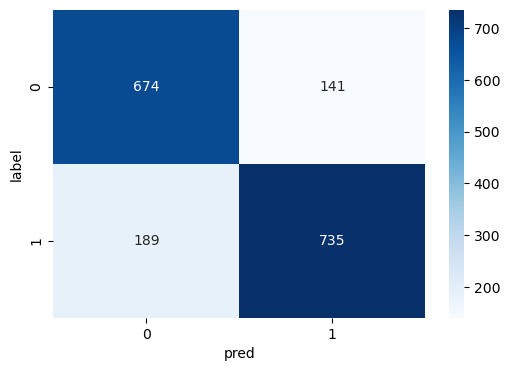

In [36]:
cm = confusion_matrix(predict(X_test,models), y_test)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('pred')
plt.ylabel('label')

In [37]:

explainer = shap.TreeExplainer(
    model = models[1],
    feature_perturbation = 'tree_path_dependent')

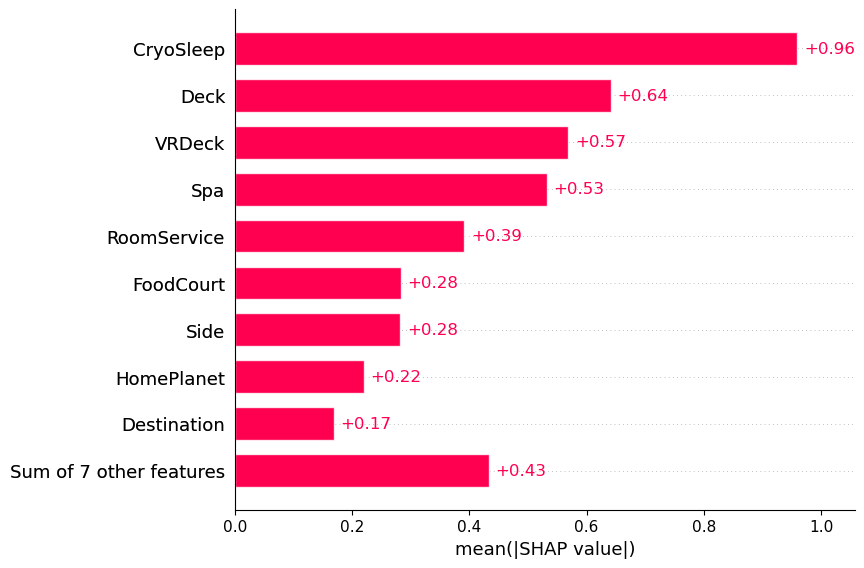

In [38]:
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
